### Relax Challenge

In [28]:
#Importing libraries
import pandas as pd
from datetime import datetime
import numpy as nP
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from tpot import TPOTClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

### 0. Importing datasets

In [3]:
#importing the first dataset
engag=pd.read_csv('takehome_user_engagement.csv')
engag.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
engag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [5]:
engag['time_stamp']=pd.to_datetime(engag['time_stamp'])
engag.index=engag['time_stamp']
engag=engag.drop(['time_stamp'], axis=1)
engag.head(3)

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1


In [6]:
# Importing the second dataset
users=pd.read_csv('takehome_users.csv', encoding='latin')
users.head(3)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0


### 1.Adopted user

An adopted user is a user who have logged into the product 3 different days in atleast one 7-days period. To do that I created first 7-days periods for each user 

In [7]:
visited=engag.groupby(['user_id']).resample('1W').sum()[['visited']]
visited.head()

visited
user_id time_stamp         
1       2014-04-27        1
2       2013-11-17        1
        2013-11-24        0
        2013-12-01        1
        2013-12-08        0

In [8]:
#Here I created a datasets of user_id which have logged in more than 3 different days in 7-days period
vis=visited[visited.visited>3]
vis.head()

visited
user_id time_stamp         
10      2013-05-05        4
        2013-05-12        5
        2013-06-09        4
        2013-06-16        5
        2013-07-07        4

In [9]:
# Users Id which are adopted user
adopted_users=list(vis.droplevel(['time_stamp'], axis=0).index.unique())

### 2. Modeling

In [10]:
#Filling Missing Values
users['last_session_creation_time'].fillna(users['last_session_creation_time'].mean(), inplace=True)

In [11]:
#Creating the target
users['adopted']=[1 if x in adopted_users else 0 for x in users['object_id']]

In [12]:
#Replacing categorical values with numerical ones
users['creation_source'].replace(['GUEST_INVITE', 'ORG_INVITE', 'SIGNUP', 'PERSONAL_PROJECTS',
       'SIGNUP_GOOGLE_AUTH'],[0,1,2,3,4], inplace=True)

In [13]:
#Converting 'creation_time' column to datetime
users['creation_time']=pd.to_datetime(users['creation_time'])

In [14]:
#converting 'creation_time' to unix timestamp
users['creation_timestamp']=users[['creation_time']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)

In [15]:
#the number of seconds from time of creation to time of last login
users['seconds']=users['last_session_creation_time']-users['creation_timestamp']

In [16]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_timestamp,seconds
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,0,1.398139e+09,1,0,11,10803.0,0,1398138810,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1,1.396238e+09,0,0,1,316.0,0,1384487104,11750400.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1,1.363735e+09,0,0,94,1525.0,0,1363734892,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,0,1.369210e+09,0,0,1,5151.0,0,1369123768,86400.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,0,1.358850e+09,0,0,193,5240.0,0,1358417660,432000.0


In [17]:
# selecting features and the target
X=users[['creation_source','seconds', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id']]
y=users['adopted']

In [18]:
# we split the dataset into the train/test datasets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=2)

In [19]:
# we use the tpot library in order to know the best algorithm to use 
tpot= TPOTClassifier(generations=1,verbosity=2,random_state=42)
tpot.fit(X_train,y_train)
## we can see a cross validation score of 95% using the KNeighborsClassifier


Generation 1 - Current best internal CV score: 0.9521875

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=75, p=2, weights=distance)


TPOTClassifier(generations=1, random_state=42, verbosity=2)

In [33]:
#Training and Fitting the model
model = KNeighborsClassifier(n_neighbors=75, p=2)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=75)

In [34]:
#Predicting and Calculating the accuracy score
y_pred=model.predict(X_test)
print(accuracy_score(y_test,y_pred))
## we can see a 93% accuracy score

0.9333333333333333


In [35]:
# Since KNeighborsClassifier does not provide a way determine feature importance, we can use other algorithm that has almost the same accuracy score
model1 = ExtraTreesClassifier(n_estimators=100, random_state=0, criterion='gini')
model1.fit(X_train, y_train)

ExtraTreesClassifier(random_state=0)

In [36]:
#Predicting and Calculating the accuracy score for the ExtraTreesClassifier
y_pred1=model1.predict(X_test)
print(accuracy_score(y_test,y_pred1))
## we can see a 93% accuracy score

0.93125


### 4. Feature Importance

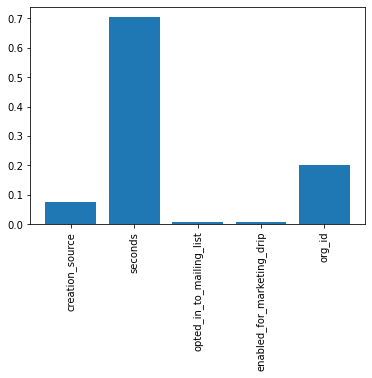

In [38]:
plt.bar(x=X_train.columns, height=model1.feature_importances_)
plt.xticks(rotation=90);

The most important features for the determining who is or who is not an adopted user is *seconds* and *org_id* 

**Reminder**: the 'seconds' column is the total number of seconds from the time a user created an account and the time of the last login that user has made